# Goal

Viz contour loss (perimeter based)

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Data Augs
from transforms import AddChannel, Iso, PadSz, MattAff, PiecewiseHistScaling, \
                       ZScale, GNoise, GBlur, \
                       RandBright, RandContrast, RandDihedral, MattAff


# Helper functions
from helpers.losses     import contour3d, contour3d_loss
from helpers.preprocess import get_data_dict_n4, mask2bbox, print_bbox
from helpers.general    import sitk2np, np2sitk, print_sitk_info, lrange
from helpers.viz        import viz_axis, viz_compare_inputs, get_mid_idx, viz_compare_outputs

# Utilities
import os
import sys
import time
import pickle
from pathlib import Path

# Input IO
import SimpleITK as sitk

# Numpy and Pytprch
import torch
import numpy as np

# Fastai
from fastai import *
from fastai.basics import *

# Get data

In [3]:
# Get data
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata"
label_src   = f"{data_src}/samir_labels"

# Get data dict
data = {}
folders = os.listdir(label_src)
for folder in folders: data.update(get_data_dict_n4(f"{label_src}/{folder}"))

# Convert data dict => items (path to MR, path to Segm tensor)
items = list(data.values())

# Orig Batch

In [4]:
iso_sz = 2
maxs   = [144, 144, 144]

item_subset = items[:10]

item_tfms  = [Iso(iso_sz), PadSz(maxs)]
tls        = TfmdLists(item_subset, item_tfms)

def get_batch(tls, bs=1, batch_tfms=[AddChannel()]):
    dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=2)
    return dls.one_batch()

orig_batch = get_batch(tls, bs=5)
orig_xb, orig_yb = orig_batch
print(orig_xb.size(), orig_yb.size())

torch.Size([5, 1, 144, 144, 144]) torch.Size([5, 1, 144, 144, 144])


# Get item

In [5]:
idx = 2
x,y = orig_xb[idx].cpu().squeeze(), orig_yb[idx].cpu().squeeze()

# Viz 3D

In [6]:
def bbox_crop(im, bbox, axis_idx=None, margin=5):
    
    a,b,c,d,e,f = bbox
    
    # margin
    a -= margin; c -= margin; e -= margin
    b += margin; d += margin; f += margin
    
    
    if axis_idx is None:
        return im[a:b, c:d, e:f]
    
    elif axis_idx == 0:
        return im[c:d, e:f]
    
    elif axis_idx == 1:
        return im[a:b, e:f]
    
    elif axis_idx == 2:
        return im[a:b, c:d]
    
    else:
        return None

In [7]:
# Source: https://github.com/kbressem/faimed3d/blob/main/nbs/01_basics.ipynb

from torch import Tensor

# export
@patch
def _strip_along(x:Tensor, dim):
    return x
#     slices = torch.unbind(x, dim)
#     slices = [s for s in slices if s.sum() != 0]
#     out = torch.stack(slices, dim)
#     return out

@patch
def strip(x:Tensor):
    return x._strip_along(-1)._strip_along(-2)._strip_along(-3)

@patch
def create_mesh(self:Tensor, cl, color, alpha):
    "creates a 3D mesh for a single class in the 3D Tensor"
    if self.ndim != 3: raise NotImplementedError('Currently only rank 3 tensors are supported for rendering')
    from skimage.measure import marching_cubes
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    im = (self == cl).float()
    verts, faces, normals, values = marching_cubes(im.permute(1, 2, 0).numpy())
    mesh = Poly3DCollection(verts[faces])
    mesh.set_facecolor(color)
    mesh.set_alpha(alpha)
    return mesh

@patch
def show_center_point(self:Tensor):
    "displays a cross in the center of the mask"
    z, x, y = self.get_nonzero_bool()
    center_z = self.get_center_id(z)
    center_x = self.get_center_id(x)
    center_y = self.get_center_id(y)
    c_val = im.max()+2
    self[center_z, center_x-50:center_x+50, center_y-5:center_y+5] = c_val
    self[center_z, center_x-5:center_x+5, center_y-50:center_y+50] = c_val
    self.show()
@patch
def create_mesh_for_classes(self:Tensor, colors, alpha):
    "applies `create_mesh` to all classes of the mask"
    classes = self.unique()[1:]
    if colors is None: colors = 'bgrcmyw'
    if len(classes) > len(colors):
        colors = random.choices(colors, k=len(classes))
    else:
        colors = colors[0:len(classes)]
    if alpha is None: alpha = (0.5, )*len(classes)
    if type(alpha) is not tuple: raise TypeError('alpha need to be a tuple.')
    if len(alpha) == 1: alpha = alpha*len(classes)
    if len(alpha) != len(classes):
        raise ValueError('Number of classes and number of alpha does not match')
    cca = list(zip(classes, colors, alpha))
    meshes = [self.create_mesh(cl=cl, color=color, alpha=alpha) for cl, color, alpha in cca]
    return meshes
@patch
def render_3d(self:Tensor, colors=None, alpha = None, symmetric=False):
    "renders the mask as a 3D object and displays it"

    im = self.strip()
    meshes = im.create_mesh_for_classes(colors = colors, alpha = alpha)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for m in meshes: ax.add_collection3d(m)
    ax.set_xlim(0, im.size(1))
    ax.set_ylim(0, im.size(2))
    ax.set_zlim(0, im.size(0))
    ax.set_facecolor('k')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
@patch
def calc_volume(self:Tensor):
    """
    Calculates the volume for a single class in the mask.
    Calculation relies on correct spacing information in the header.
    Results are given in mm**3
    """
    x,y,z = 1,1,1
    voxel_size = x*y*z
    self.volume = {'background': self._calc_vol_per_class(0, voxel_size)}
    self.volume['total_mask_volume'] = self.size(0)*self.size(1)*self.size(2)*voxel_size - self.volume['background']
    for c in self.unique()[1:]:
        name = 'class '+str(int(c))
        self.volume[name] = self._calc_vol_per_class(c, voxel_size)
    print(self.volume)
    return self.volume["class 1"]

@patch
def _calc_vol_per_class(self:Tensor, class_idx, voxel_size):
    "calculates volume of the void, whole mask and for each class in the mask"
    return float((self == class_idx).sum() * voxel_size)

Bbox: (65, 80, 74, 86, 64, 73)
<class 'torch.Tensor'>


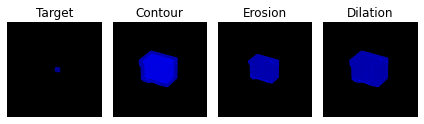

In [8]:
# 3D
from mpl_toolkits import mplot3d
from matplotlib import colors
%matplotlib inline

bbox = mask2bbox(np.asarray(y))
print(f"Bbox: {bbox}")

# Crop
x_crop = bbox_crop(x,bbox)
y_crop = bbox_crop(y, bbox)

# calculate 3d
x1 = y_crop.float().unsqueeze(0).unsqueeze(0)
min_pool_x1     = torch.nn.functional.max_pool3d(x1*-1, (3, 3, 3), 1, 1)*-1
max_min_pool_x1 = torch.nn.functional.max_pool3d(min_pool_x1, (3, 3, 3), 1, 1)
contour         = torch.nn.functional.relu(max_min_pool_x1 - min_pool_x1)

contour         = contour.squeeze()
min_pool_x1     = min_pool_x1.squeeze()
max_min_pool_x1 = max_min_pool_x1.squeeze()

print(type(min_pool_x1))

# Plot
fig = plt.figure()

ax1 = fig.add_subplot(141, projection='3d')
ax2 = fig.add_subplot(142, projection='3d')
ax3 = fig.add_subplot(143, projection='3d')
ax4 = fig.add_subplot(144, projection='3d')

axes = [ax1, ax2, ax3, ax4]
ims  = [y, contour, min_pool_x1, max_min_pool_x1]
titles = ["Target", "Contour", "Erosion", "Dilation"]

colors=None
alpha = None

for ax, im, title in zip(axes, ims, titles):
    im = im.strip()
    meshes = im.create_mesh_for_classes(colors = colors, alpha = alpha)
    for m in meshes: ax.add_collection3d(m)
    ax.set_xlim(0, im.size(1))
    ax.set_ylim(0, im.size(2))
    ax.set_zlim(0, im.size(0))
    ax.set_facecolor('k')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [9]:
y_vol = y.calc_volume()
min_vol = min_pool_x1.calc_volume()
max_vol = max_min_pool_x1.calc_volume()
contour_vol = contour.calc_volume()

{'background': 2984498.0, 'total_mask_volume': 1486.0, 'class 1': 1486.0}
{'background': 9660.0, 'total_mask_volume': 790.0, 'class 1': 790.0}
{'background': 8966.0, 'total_mask_volume': 1484.0, 'class 1': 1484.0}
{'background': 9756.0, 'total_mask_volume': 694.0, 'class 1': 694.0}


In [10]:
# side lens
print(bbox)
side1 = bbox[1]-bbox[0]
side2 = bbox[3]-bbox[2]
side3 = bbox[5]-bbox[4]
print(side1, side2, side3)

# correction for idx 2
# side1 -= 1

volume = side1 * side2 * side3
surface_area = 2 * (side1 * side2) + 2 * (side1*side3) + 2 * (side2 * side3)

print(f"Volume", volume, "y_vol", y_vol, "Diff", volume-y_vol)
print(f"Surface area", surface_area, "contour ", contour_vol, surface_area - contour_vol)
print(f"ratio vol/surface area ", volume/surface_area, y_vol/contour_vol)
print(f"Norm by vol: Surface area", surface_area/y_vol, "contour ", contour_vol/y_vol, (surface_area - contour_vol)/y_vol)

(65, 80, 74, 86, 64, 73)
15 12 9
Volume 1620 y_vol 1486.0 Diff 134.0
Surface area 846 contour  694.0 152.0
ratio vol/surface area  1.9148936170212767 2.1412103746397695
Norm by vol: Surface area 0.5693135935397039 contour  0.4670255720053836 0.10228802153432032


# Viz 2d

Bbox (65, 80, 74, 86, 64, 73)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


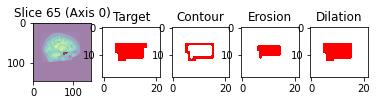

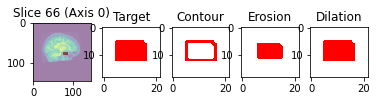

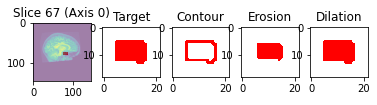

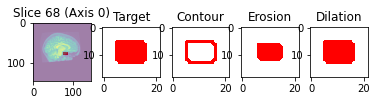

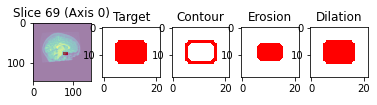

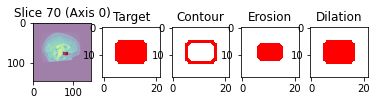

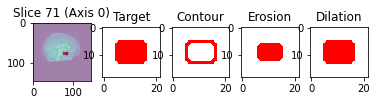

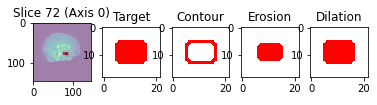

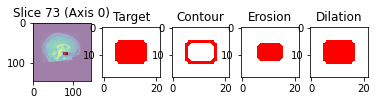

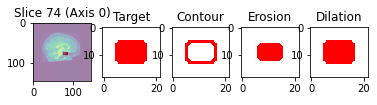

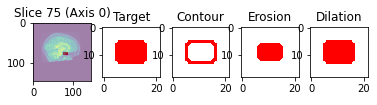

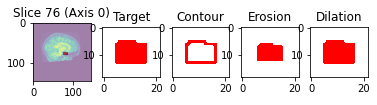

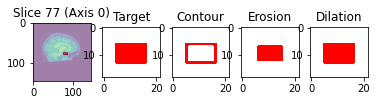

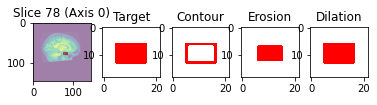

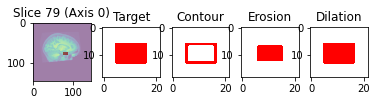

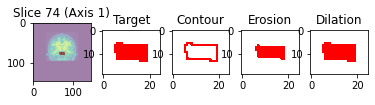

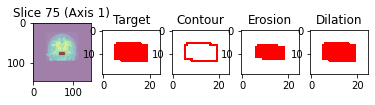

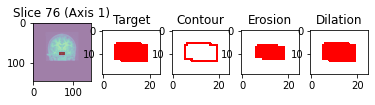

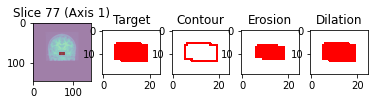

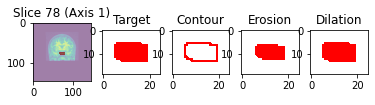

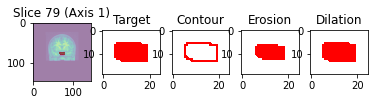

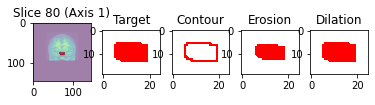

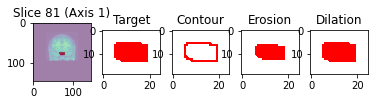

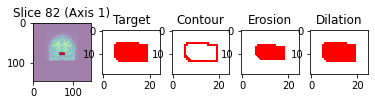

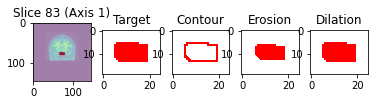

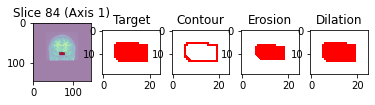

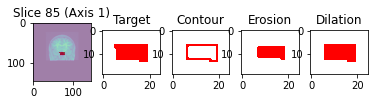

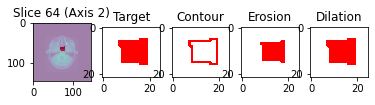

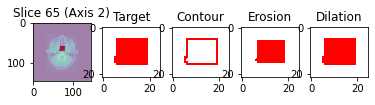

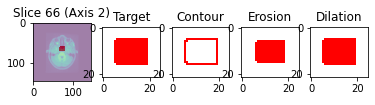

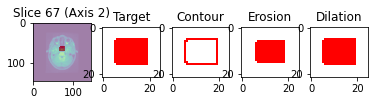

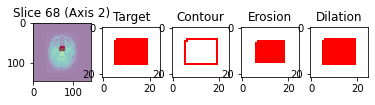

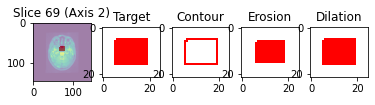

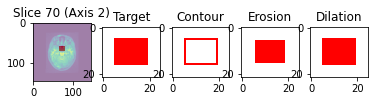

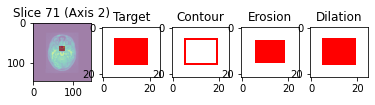

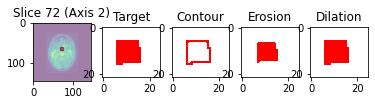

In [11]:
from matplotlib import colors
bin_cmap2  = colors.ListedColormap(['white', 'red'])

bbox = mask2bbox(np.asarray(y))
print("Bbox", bbox)

slice_ranges = [(bbox[2*i], bbox[2*i+1]) for i in range(3)]

# take slice
for axis_idx in range(3):
    slice_start, slice_end = slice_ranges[axis_idx]
    #slice_mid = slice_start + (slice_end-slice_start)//2
    #slice_start, slice_end = slice_mid-2, slice_mid+2
    
    for slice_idx in range(slice_start, slice_end):
        #slice_idx = slice_start + (slice_end - slice_start)//2

        x_slice = np.take(np.asarray(x), slice_idx, axis=axis_idx)
        y_slice = np.take(np.asarray(y), slice_idx, axis=axis_idx)
        
        # calculate  2d
        x1 = torch.tensor(y_slice).float().unsqueeze(0).unsqueeze(0)
        min_pool_x1     = torch.nn.functional.max_pool2d(x1*-1, (3, 3), 1, 1)*-1
        max_min_pool_x1 = torch.nn.functional.max_pool2d(min_pool_x1, (3, 3), 1, 1)
        contour         = torch.nn.functional.relu(max_min_pool_x1 - min_pool_x1)
        
        min_pool_x1 = np.asarray(min_pool_x1.squeeze())
        max_min_pool_x1 = np.asarray(max_min_pool_x1.squeeze())
        y_slice_contour = np.asarray(contour.squeeze().long())
        
        _, axes = plt.subplots(nrows=1, ncols=5)
        axes[0].imshow(np.rot90(x_slice))
        axes[0].imshow(np.rot90(y_slice), alpha=0.5, cmap=bin_cmap2)
        axes[1].imshow(np.rot90(bbox_crop(y_slice, bbox, axis_idx)), cmap=bin_cmap2)
        axes[2].imshow(np.rot90(bbox_crop(y_slice_contour, bbox, axis_idx)), cmap=bin_cmap2)
        axes[3].imshow(np.rot90(bbox_crop(min_pool_x1, bbox, axis_idx)), cmap=bin_cmap2)
        axes[4].imshow(np.rot90(bbox_crop(max_min_pool_x1, bbox, axis_idx)), cmap=bin_cmap2)

        axes[0].set_title(f"Slice {slice_idx} (Axis {axis_idx})")
        axes[1].set_title(f"Target")
        axes[2].set_title(f"Contour")
        axes[3].set_title(f"Erosion")
        axes[4].set_title(f"Dilation")

# Contour Loss

In [12]:
# DATALOADER PARAMS
bs          = 4
nepochs     = 30
num_workers = 2

# PREPROCESS (Isotropic, PadResize)
# iso       = 3
# maxs      = [87, 90, 90]

iso       = 2
maxs      = [144, 144, 144]

# Train:Valid:Test = 60:20:20
train_pct, valid_pct = .60, .20

# Paths

In [14]:
import os

# Paths to (1) code (2) data (3) saved models
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata"
model_src   = "/gpfs/data/oermannlab/private_data/DeepPit/saved_models"

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"
label_src   = f"{data_src}/samir_labels"
ABIDE_src   = f"{data_src}/ABIDE"

# print
print("Folders in data src: ", end=""); print(*os.listdir(data_src), sep=", ")
print("Folders in label src (data w labels): ", end=""); print(*os.listdir(label_src), sep=", ")
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

Folders in data src: ICMB, ABVIB (1).zip, central.xnat.org, ADNI, PPMI, Oasis_long, samir_labels, ACRIN-FMISO-Brain, LGG-1p19qDeletion, REMBRANDT, AIBL, CPTAC-GBM, TCGA-GBM, TCGA-LGG, ABVIB, ABIDE, AIBL.zip
Folders in label src (data w labels): 50155-50212, 50313-50372, 50213-50312, 50373-50453, 50002-50153
Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE


# Imports

In [15]:
%load_ext autoreload
%autoreload 2

# imports (# Piece)
from transforms import AddChannel, Iso, PadSz,\
                       ZScale, \
                       GNoise, GBlur,\
                       RandBright, RandContrast, \
                       RandDihedral, MattAff
        
from condseg_transforms import (
    AddAtlas, IsoAtlas, 
    ZScaleAtlas, AddChAtlas, 
    MattAffAtlas, ConcatChannel)


from helpers.losses import dice_score, dice_loss, dice_ce_loss, log_cosh_dice_loss, perim_loss

# MONAI
from monai.losses        import DiceLoss
from monai.metrics       import DiceMetric
from monai.networks.nets import VNet, UNet

# Utilities
import os, sys, gc, time, pickle
from pathlib import Path

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *
from fastai.callback.all import SaveModelCallback
from fastai.callback.tensorboard import TensorBoardCallback

# PyTorch
from torch import nn

# Obelisk
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils  import *
from models import obelisk_visceral, obeliskhybrid_visceral

# Helper functions
from helpers.preprocess import get_data_dict_n4, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general    import sitk2np, np2sitk, print_sitk_info, lrange, lmap, numbers2groups, print_hardware_stats
from helpers.viz        import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.time       import time_one_batch, get_time_id

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [16]:
model_fns = sorted(Path(model_src).iterdir(), key=os.path.getmtime, reverse=True)
model_fns = [str(p) for p in model_fns if str(p).endswith(".pth")]
print(*[model_fn[len(model_src):] for model_fn in model_fns], sep="\n")

/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626445575_Fri_Jul_07_2021_hr_10_min_26.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626440381_Fri_Jul_07_2021_hr_08_min_59.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626439241_Fri_Jul_07_2021_hr_08_min_40.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384969_Thu_Jul_07_2021_hr_17_min_36.pth
/OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384854_Thu_Jul_07_2021_hr_17_min_34.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384611_Thu_Jul_07_2021_hr_17_min_30.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626381455_Thu_Jul_07_2021_hr_16_min_37.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626380514_Thu_Jul_07_2021_hr_16_min

In [17]:
#model_fn = "OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_67_epochs_30_time_1626043621_Sun_Jul_07_2021_hr_18_min_47.pth"
model_fn = Path(model_fns[0]).name

model_fn = "OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384854_Thu_Jul_07_2021_hr_17_min_34.pth"
test_fn  = model_fn[:-4] + "_test_items.pkl"

# print
print(f"Model Name: {model_fn[:-4]}")

Model Name: OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384854_Thu_Jul_07_2021_hr_17_min_34


In [18]:
# get parameters

def get_param(fn, prefix, suffix):
    start = fn.index(prefix)
    end   = fn.index(suffix)
    ints = fn[start+len(prefix):end].split("_")
    try:
        if len(ints) == 1: return int(ints[0])
        return [int(x) for x in ints]
    except:
        if len(ints) == 1: return ints[0]
        return ints

model_type = model_fn[0:model_fn.index("_")]
loss_type  = model_fn[model_fn.index("_")+1:model_fn.index("_iso")]

iso_sz     = get_param(model_fn, "iso_", "mm")
maxs       = get_param(model_fn, "pad_", "_bs")
bs         = get_param(model_fn, "bs_", "_test")
nepochs    = get_param(model_fn, "epochs_", "_time")

# get test items
with open(f"{model_src}/{test_fn}", "rb") as input_file:
    test_items = pickle.load(input_file)
    
# get all items
data = {}
folders = os.listdir(label_src)
for folder in folders: data.update(get_data_dict_n4(f"{label_src}/{folder}"))
items = list(data.values())

# print
print(f"Model type: {model_type}. Loss type: {loss_type}. Iso: {iso_sz}. PadResize to: {maxs}. bs = {bs}. nepochs = {nepochs}.")
print(f"Num test items: {len(test_items)}")
print(f"Num items: {len(items)}")

Model type: OBELISKHYBRID. Loss type: log_cosh_dice_loss. Iso: 2. PadResize to: [144, 144, 144]. bs = 2. nepochs = 60.
Num test items: 66
Num items: 335


# Transforms

In [19]:
# tfms
if model_type.startswith("CONDSEG"):
    item_tfms  = [AddAtlas(items), IsoAtlas(iso_sz), PadSz(maxs)]
    batch_tfms = [ZScaleAtlas(), AddChAtlas(), ConcatChannel()]

else:
    item_tfms  = [Iso(iso_sz), PadSz(maxs)]
    batch_tfms = [ZScale(), AddChannel()]

# Dataloaders

In [20]:
# time it
start = time.time()

# tls
tls = TfmdLists(test_items, item_tfms)

# dls
dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)

# GPU
dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(test_items)} items")

# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(f"bs = {bs}, n_train = {len(dls.train_ds)}, n_valid = {len(dls.valid_ds)}, n_test_items = {len(test_items)}, n = {len(items)}")

Elapsed time: 0.286207914352417 s for 66 items
<class 'tuple'> torch.Size([2, 1, 144, 144, 144]) torch.Size([2, 1, 144, 144, 144])
bs = 2, n_train = 66, n_valid = 0, n_test_items = 66, n = 335


# Models

In [ ]:
if model_type == "VNET":
    # https://docs.monai.io/en/latest/networks.html#vnet
    device = torch.device("cuda:0")
    model = VNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
    ).to(device)
    
elif model_type == "UNET3D":
    device = torch.device("cuda:0")
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    
elif model_type.startswith("CONDSEG"):
    device = torch.device("cuda:0")
    model = UNet(
        dimensions=3,
        in_channels=3,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

elif model_type == "OBELISKHYBRID":
    full_res = maxs
    model    = obeliskhybrid_visceral(num_labels=2, full_res=full_res)
    model.cuda()
    
else:
    pass

# Loss

if loss_type == "log_cosh_dice_loss":
    loss_function = log_cosh_dice_loss
elif loss_type == "DICE":
    loss_function = dice_loss
    
elif loss_type == "perim_loss":
    loss_function = perim_loss
else:
    loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=False)

# check
print("Check")
b = dls.one_batch()
xb,yb = b
print(f"Batch: {len(b)}. xb: {xb.shape}, yb: {yb.shape}")
predb = model(xb)
print(f"Pred batch: {predb.shape}")
loss = loss_function(predb, yb)
print(f"Loss: {loss}")

In [22]:
# Learner`m

In [ ]:
import gc
gc.collect()

In [ ]:
learn = Learner(dls       = dls, 
                model     = model, 
                loss_func = loss_function,
                metrics   = dice_score)

# load model fname w/o .pth extension
learn.load(f"{model_src}/{model_fn[:-4]}")

In [ ]:
# all predictions, 67 items, 4 workers, 15sec
start = time.time()
predictions, targets = learn.get_preds(ds_idx=0)
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(test_items)} items.")

print(predictions.shape, targets.shape)
print(targets[0].shape, predictions[0].shape)

In [21]:
# Distribution probs
probs = predictions.softmax(1)[:,1]

Check
Batch: 2. xb: torch.Size([2, 1, 144, 144, 144]), yb: torch.Size([2, 1, 144, 144, 144])
Pred batch: torch.Size([2, 2, 144, 144, 144])
Loss: 0.4317914545536041


Elapsed: 15.07 s for 66 items.
torch.Size([66, 2, 144, 144, 144]) torch.Size([66, 1, 144, 144, 144])
torch.Size([1, 144, 144, 144]) torch.Size([2, 144, 144, 144])


In [24]:
probs.shape

torch.Size([66, 144, 144, 144])

In [26]:
contour3d_loss??

In [30]:
input = predictions
print(input.shape)
b, _, d, w, h = input.shape

torch.Size([66, 2, 144, 144, 144])


In [42]:
contour3d_loss(predictions, targets)

tensor([0.0154])

In [45]:
dice_loss = log_cosh_dice_loss(input, targets)
contour_loss = contour3d_loss(input, targets)

In [46]:
print(dice_loss, contour_loss)

tensor(0.0151) tensor([0.0154])


In [52]:
# pred = probability map
pred   = predictions.softmax(1)[:,1].unsqueeze(1) # input[:,1].float().unsqueeze(1)
target = targets.float()

# calculate perim lenth, summed over CDHW
cl_pred         = contour3d(pred).sum(axis=(2,3,4))
target_skeleton = contour3d(target).sum(axis=(2,3,4))

# mse loss
big_pen = (cl_pred - target_skeleton) ** 2
contour_loss = big_pen / (d * w * h)

# average over batch
loss = contour_loss.mean(axis=0)[0]

In [53]:
loss.shape

torch.Size([1])

In [57]:
loss[0]

tensor(0.0154)

In [55]:
contour_loss.shape

torch.Size([66, 1])

In [59]:
contour_loss.shape

torch.Size([66, 1])